In [2]:
import pickle
import mne
import numpy as np
from collections import Counter
import networkx as nx
from collections import defaultdict
from sklearn.manifold import SpectralEmbedding
import matplotlib.pyplot as plt
import matplotlib
import pickle
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.stats import entropy
from sklearn.decomposition import PCA
import seaborn as sns
import pathlib
from tqdm import tqdm
from mne.preprocessing import ICA
from scipy.signal import butter, filtfilt
from pathlib import Path


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/donaf-strange/.local/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/donaf-strange/.local/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/donaf-strange/.local/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io_loop.start()
  File 

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.




A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/donaf-strange/.local/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/donaf-strange/.local/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/donaf-strange/.local/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io_loop.start()
  File 

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.



sfreq = 500  # Hz

with open("/home/donaf-strange/LAB_WORK/eeg_arithmetic_project/data/all_rest_eeg_by_participant.pkl", 'rb') as f:
    rest_eeg_dict = pickle.load(f)

with open("/home/donaf-strange/LAB_WORK/eeg_arithmetic_project/data/all_task_eeg_by_participant.pkl", 'rb') as f:
    task_eeg_dict = pickle.load(f)


# Define mapping for EEG channels
channel_mapping = {
    "EEG Fp1": "Fp1", "EEG Fp2": "Fp2", "EEG F3": "F3", "EEG F4": "F4",
    "EEG F7": "F7", "EEG F8": "F8", "EEG T3": "T3", "EEG T4": "T4",
    "EEG C3": "C3", "EEG C4": "C4", "EEG T5": "T5", "EEG T6": "T6",
    "EEG P3": "P3", "EEG P4": "P4", "EEG O1": "O1", "EEG O2": "O2",
    "EEG Fz": "Fz", "EEG Cz": "Cz", "EEG Pz": "Pz"
}
clean_ch_names = list(channel_mapping.values())

# Bandpass filter function (optional if not using MNE’s built-in filter)
def bandpass_filter(data, low, high, fs=500, order=5):
    nyq = 0.5 * fs
    low /= nyq
    high /= nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data, axis=1)

# ICA + Filtering for one subject
def preprocess_subject(raw: mne.io.Raw):
    raw = raw.copy()

    # Rename channels
    raw.rename_channels(lambda ch: ch.replace('EEG ', '') if ch.startswith('EEG ') else ch)

    # Pick only EEG
    raw.pick(list(channel_mapping.values()))


    # Set average reference
    raw.set_eeg_reference('average', projection=False)

    # ICA (warns about no high-pass filtering, which is okay for now)
    ica = ICA(n_components=15, random_state=97, max_iter='auto')
    ica.fit(raw)
    raw = ica.apply(raw)

    # Filter into EEG bands
    bands = {
        'theta': (4, 8),
        'alpha': (8, 12),
        'beta': (12, 30),
        'gamma': (30, 45)
    }

    band_data = {}
    for band, (low, high) in bands.items():
        filtered_raw = raw.copy().filter(l_freq=low, h_freq=high, fir_design='firwin')
        band_data[band] = filtered_raw.get_data()  # shape: (n_channels, n_samples)

    return band_data

# Batch preprocessing
def batch_preprocess(eeg_dict, label='UNKNOWN'):
    preprocessed = {}
    for subject_id, raw in eeg_dict.items():
        try:
            band_data = preprocess_subject(raw)
            preprocessed[subject_id] = band_data
            print(f"✅ Preprocessed {label} subject {subject_id}")
        except Exception as e:
            print(f"❌ Failed {label} subject {subject_id}: {e}")
    return preprocessed

# Run for both rest and task data
preprocessed_rest = batch_preprocess(rest_eeg_dict, label='REST')
preprocessed_task = batch_preprocess(task_eeg_dict, label='TASK')

# Save outputs for Step 2
Path("preprocessed").mkdir(exist_ok=True)
with open("preprocessed/preprocessed_rest.pkl", "wb") as f:
    pickle.dump(preprocessed_rest, f)

with open("preprocessed/preprocessed_task.pkl", "wb") as f:
    pickle.dump(preprocessed_task, f)


In [3]:
# Sampling rate
sfreq = 500  # Hz

# Load your datasets
with open("/home/donaf-strange/LAB_WORK/eeg_arithmetic_project/data/all_rest_eeg_by_participant.pkl", 'rb') as f:
    rest_eeg_dict = pickle.load(f)

with open("/home/donaf-strange/LAB_WORK/eeg_arithmetic_project/data/all_task_eeg_by_participant.pkl", 'rb') as f:
    task_eeg_dict = pickle.load(f)

# Define mapping for EEG channels (from raw names to standard ones)
channel_mapping = {
    "EEG Fp1": "Fp1", "EEG Fp2": "Fp2", "EEG F3": "F3", "EEG F4": "F4",
    "EEG F7": "F7", "EEG F8": "F8", "EEG T3": "T3", "EEG T4": "T4",
    "EEG C3": "C3", "EEG C4": "C4", "EEG T5": "T5", "EEG T6": "T6",
    "EEG P3": "P3", "EEG P4": "P4", "EEG O1": "O1", "EEG O2": "O2",
    "EEG Fz": "Fz", "EEG Cz": "Cz", "EEG Pz": "Pz"
}

# Preprocessing for one subject
def preprocess_subject(raw: mne.io.Raw, subject_id=None, label='UNKNOWN', n_components=0.99):
    raw = raw.copy()

    # Rename EEG channels
    raw.rename_channels(lambda ch: ch.replace("EEG ", "") if ch.startswith("EEG ") else ch)

    # Keep only EEG channels
    raw.pick(list(channel_mapping.values()))

    # Set average reference
    raw.set_eeg_reference('average', projection=False)

    # ICA - fit on high-pass filtered copy only (NOT applied)
    raw_ica = raw.copy().filter(l_freq=1.0, h_freq=None, fir_design='firwin', verbose=False)
    ica = ICA(n_components=n_components, random_state=97, max_iter='auto')
    ica.fit(raw_ica)

    # Apply ICA to full-band raw signal
    raw = ica.apply(raw)
    print(f"📊 Subject {subject_id} | {label} | ICA components used: {ica.n_components_}")

    # Frequency bands
    bands = {
        'theta': (4, 8),
        'alpha': (8, 12),
        'beta': (12, 30),
        'gamma': (30, 45),
        'broadband': (1, 45)  # Optional: full useful band
    }

    # Band-specific filtered data
    band_data = {}
    for band, (low, high) in bands.items():
        raw_band = raw.copy().filter(l_freq=low, h_freq=high, fir_design='firwin', verbose=False)
        band_data[band] = raw_band.get_data()

    return band_data


# Batch preprocessing
def batch_preprocess(eeg_dict, label='UNKNOWN'):
    preprocessed = {}
    for subject_id, raw in eeg_dict.items():
        try:
            band_data = preprocess_subject(raw, subject_id=subject_id, label=label)
            preprocessed[subject_id] = band_data
            print(f"✅ Preprocessed {label} subject {subject_id}")
        except Exception as e:
            print(f"❌ Failed {label} subject {subject_id}: {e}")
    return preprocessed





In [4]:
# Save outputs for Step 2
Path("preprocessed").mkdir(exist_ok=True)

In [5]:
preprocessed_task = batch_preprocess(task_eeg_dict, label='TASK')

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 15 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
📊 Subject 2 | TASK | ICA components used: 15
✅ Preprocessed TASK subject 2
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 13 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (13 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
📊 Subject 26 | TASK | ICA components used: 13
✅ Preprocessed TASK subject 26
EEG channel type sel

In [7]:
with open("preprocessed/preprocessed_task.pkl", "wb") as f:
    pickle.dump(preprocessed_task, f)

In [11]:
preprocessed_task = batch_preprocess(rest_eeg_dict, label='TASK')

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 14 components
Fitting ICA took 1.1s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
📊 Subject 0 | TASK | ICA components used: 14
✅ Preprocessed TASK subject 0
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 14 components
Fitting ICA took 1.4s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
📊 Subject 29 | TASK | ICA components used: 14
✅ Preprocessed TASK subject 29
EEG channel type sel

In [13]:
preprocessed_rest = batch_preprocess(task_eeg_dict, label='REST')

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 15 components
Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
📊 Subject 2 | REST | ICA components used: 15
✅ Preprocessed REST subject 2
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 13 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (13 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
📊 Subject 26 | REST | ICA components used: 13
✅ Preprocessed REST subject 26
EEG channel type sel

In [14]:
with open("preprocessed/preprocessed_rest.pkl", "wb") as f:
    pickle.dump(preprocessed_rest, f)

In [15]:

def binarize_subject_band(band_data, method='median'):
    binary_band = {}

    for band, data in band_data.items():
        n_channels, n_samples = data.shape
        binary = np.zeros_like(data, dtype=np.uint8)

        for ch in range(n_channels):
            if method == 'median':
                threshold = np.median(data[ch])
            elif method == 'quantile':
                threshold = np.quantile(data[ch], 0.5)
            else:
                raise ValueError("Unsupported binarization method.")

            binary[ch] = (data[ch] > threshold).astype(np.uint8)

        binary_band[band] = binary

    return binary_band

In [16]:
def batch_binarize(preprocessed_dict, label='UNKNOWN'):
    binary_all = {}
    for subj_id, band_data in preprocessed_dict.items():
        try:
            binary_all[subj_id] = binarize_subject_band(band_data)
            print(f"✅ Binarized {label} subject {subj_id}")
        except Exception as e:
            print(f"❌ Failed {label} subject {subj_id}: {e}")
    return binary_all

In [17]:
# Load preprocessed filtered data
with open("preprocessed/preprocessed_rest.pkl", "rb") as f:
    preprocessed_rest = pickle.load(f)

with open("preprocessed/preprocessed_task.pkl", "rb") as f:
    preprocessed_task = pickle.load(f)

# Run
binary_rest = batch_binarize(preprocessed_rest, label='REST')
binary_task = batch_binarize(preprocessed_task, label='TASK')

# Save
Path("binarized").mkdir(exist_ok=True)
with open("binarized/binary_rest.pkl", "wb") as f:
    pickle.dump(binary_rest, f)

with open("binarized/binary_task.pkl", "wb") as f:
    pickle.dump(binary_task, f)


✅ Binarized REST subject 2
✅ Binarized REST subject 26
✅ Binarized REST subject 20
✅ Binarized REST subject 12
✅ Binarized REST subject 21
✅ Binarized REST subject 7
✅ Binarized REST subject 35
✅ Binarized REST subject 31
✅ Binarized REST subject 18
✅ Binarized REST subject 34
✅ Binarized REST subject 29
✅ Binarized REST subject 1
✅ Binarized REST subject 13
✅ Binarized REST subject 6
✅ Binarized REST subject 14
✅ Binarized REST subject 3
✅ Binarized REST subject 19
✅ Binarized REST subject 17
✅ Binarized REST subject 10
✅ Binarized REST subject 24
✅ Binarized REST subject 16
✅ Binarized REST subject 30
✅ Binarized REST subject 11
✅ Binarized REST subject 22
✅ Binarized REST subject 8
✅ Binarized REST subject 25
✅ Binarized REST subject 9
✅ Binarized REST subject 15
✅ Binarized REST subject 0
✅ Binarized REST subject 27
✅ Binarized REST subject 4
✅ Binarized REST subject 33
✅ Binarized REST subject 23
✅ Binarized REST subject 28
✅ Binarized REST subject 5
✅ Binarized REST subject 32
✅ 

Step 3: Ising Model Fitting (Pairwise Maximum Entropy)
🎯 Goal:

Fit an Ising model to your binarized EEG state vectors to capture the underlying energy landscape of brain states.

Each state is a binary vector of shape:

X ∈ {0,1}^N → where N = number of EEG channels (19)

The Ising model estimates:
P(s)∝exp⁡(∑ihisi+∑i<jJijsisj)
P(s)∝exp(i∑​hi​si​+i<j∑​Jij​si​sj​)

    hihi​: bias (local field)

    JijJij​: pairwise interaction

    P(s)P(s): probability of brain state ss

📦 What You’ll Need:

    Your binarized data per subject per band (from binary_rest.pkl and binary_task.pkl)

    For each subject & band:

        Convert to (n_samples, n_channels)

        Fit Ising model (using pseudo-likelihood estimation)



In [18]:
def fit_pairwise_ising(X):
    """
    Fit Ising model using logistic regression (pseudo-likelihood method).
    Input: X ∈ {0,1}^n_samples × n_channels
    Output: h ∈ R^n, J ∈ R^{n × n}
    """
    X = X.copy().astype(int)  # Fix: convert from uint8 → int
    X[X == 0] = -1  # Convert 0 → -1
    n_samples, n_channels = X.shape

    h = np.zeros(n_channels)
    J = np.zeros((n_channels, n_channels))

    for i in range(n_channels):
        X_i = X[:, i]
        X_rest = np.delete(X, i, axis=1)

        model = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000)
        model.fit(X_rest, X_i)

        h[i] = model.intercept_[0]
        coefs = model.coef_[0]
        idx = 0
        for j in range(n_channels):
            if j == i:
                continue
            J[i, j] = coefs[idx]
            idx += 1

    # Symmetrize J
    J = 0.5 * (J + J.T)

    return h, J


In [19]:
def fit_ising_batch(binary_data):
    ising_models = {}
    for subj_id in tqdm(binary_data):
        ising_models[subj_id] = {}
        for band, binary in binary_data[subj_id].items():
            X = binary.T  # shape: (timepoints, channels)
            h, J = fit_pairwise_ising(X)
            ising_models[subj_id][band] = {
                'h': h,
                'J': J
            }
    return ising_models

In [21]:
from sklearn.linear_model import LogisticRegression

# Load binarized data
with open("binarized/binary_rest.pkl", "rb") as f:
    binary_rest = pickle.load(f)

with open("binarized/binary_task.pkl", "rb") as f:
    binary_task = pickle.load(f)

# Run fitting
ising_rest = fit_ising_batch(binary_rest)
ising_task = fit_ising_batch(binary_task)

# Save results
Path("ising_models").mkdir(exist_ok=True)
with open("ising_models/ising_rest.pkl", "wb") as f:
    pickle.dump(ising_rest, f)

with open("ising_models/ising_task.pkl", "wb") as f:
    pickle.dump(ising_task, f)


100%|██████████| 36/36 [01:23<00:00,  2.33s/it]


Energy Landscape Feature Extraction

We’ll extract dynamical features from the Ising model for each subject and band.
✅ Goal

Given Ising parameters (h,J)(h,J), compute features such as:
Feature	Meaning
Local Minima	Number of stable states
Energy per State	Energy E(s)=−hTs−sTJsE(s)=−hTs−sTJs for all possible binary states
Basin Size	Number of neighboring states that fall into each attractor
Transition Entropy	Uncertainty of moving from one state to another

We'll start with the first two: energy landscape and local minima.
⚠️ Limitation:

You have 19 channels → 219=524,288219=524,288 possible states
🧠 That's manageable. We’ll use brute-force enumeration.
✅ Step-by-Step Plan
🔢 1. Enumerate All Possible States
📉 2. Compute Energy for Each State
📍 3. Find Local Minima (states with lower energy than all Hamming neighbors)
📊 4. Count Minima and Compute Mean Basin Size


In [ ]:
from itertools import product

def all_binary_states(n):
    """Return all 2^n binary states of length n as np.array of shape (2^n, n)"""
    return np.array(list(product([1, -1], repeat=n)))  # use {-1, +1}


Compute Energy
E(s)=−h^⊤*s−s^⊤*J*s

In [ ]:
def compute_energies(states, h, J):
    linear = - np.dot(states, h)
    quad = - np.einsum('ij,ij->i', np.dot(states, J), states)
    return linear + quad  # shape: (2^n,)

In [ ]:
def hamming_neighbors(index, n_bits):
    """
    Return indices of neighbors of a binary state by flipping one bit.
    Input: index ∈ [0, 2^n), n_bits = number of bits (channels)
    Output: list of neighbor indices
    """
    return [index ^ (1 << i) for i in range(n_bits)]

def find_local_minima(energies):
    n_states = len(energies)
    n_bits = int(np.log2(n_states))
    minima = []
    for i in range(n_states):
        neighbors = hamming_neighbors(i, n_bits)
        if all(energies[i] < energies[j] for j in neighbors):
            minima.append(i)
    return minima


Combined Function to Run Per Subject/Band

In [ ]:
def extract_landscape_features(h, J):
    n = len(h)
    states = all_binary_states(n)  # shape: (2^n, n)
    energies = compute_energies(states, h, J)

    minima_indices = find_local_minima(energies)
    num_minima = len(minima_indices)
    
    # Normalize energies to [0, 1]
    norm_energies = (energies - energies.min()) / (energies.max() - energies.min())

    return {
        'num_minima': num_minima,
        'energies': energies,
        'minima_indices': minima_indices,
        'normalized_energies': norm_energies
    }


In [ ]:
def batch_extract_features(ising_dict):
    all_features = {}
    for subj_id in tqdm(ising_dict):
        all_features[subj_id] = {}
        for band in ising_dict[subj_id]:
            h = ising_dict[subj_id][band]['h']
            J = ising_dict[subj_id][band]['J']
            all_features[subj_id][band] = extract_landscape_features(h, J)
    return all_features


In [ ]:
with open("ising_models/ising_rest.pkl", "rb") as f:
    ising_rest = pickle.load(f)

with open("ising_models/ising_task.pkl", "rb") as f:
    ising_task = pickle.load(f)

# Run feature extraction
features_rest = batch_extract_features(ising_rest)
features_task = batch_extract_features(ising_task)

# Save
Path("landscape_features").mkdir(exist_ok=True)
with open("landscape_features/features_rest.pkl", "wb") as f:
    pickle.dump(features_rest, f)

with open("landscape_features/features_task.pkl", "wb") as f:
    pickle.dump(features_task, f)

100%|██████████| 36/36 [03:43<00:00,  6.22s/it]


In [22]:
# Good/Bad group definitions using numeric keys as strings
bad_counters = ['0', '4', '6', '9', '10', '14', '19', '21', '22', '30']
good_counters = ['1', '2', '3', '5', '7', '8', '11', '12', '13', '15', '16', '17',
                 '18', '20', '23', '24', '25', '26', '27', '28', '29', '31', '32',
                 '33', '34', '35']


In [ ]:
def summarize_features(landscape):
    """
    Input: one subject's features per band
    Output: summary metrics: num_minima, energy entropy, min_energy
    """
    energies = landscape['normalized_energies']
    p = np.exp(-energies)  # unnormalized Boltzmann distribution
    p /= p.sum()

    return {
        'num_minima': landscape['num_minima'],
        'energy_entropy': entropy(p),
        'min_energy': np.min(landscape['energies'])
    }


In [ ]:
def aggregate_group_features(features_dict, subjects, band='alpha'):
    summary_list = []
    for sid in subjects:
        if sid in features_dict and band in features_dict[sid]:
            summary = summarize_features(features_dict[sid][band])
            summary_list.append(summary)
    return summary_list


In [ ]:
from scipy.stats import ttest_ind, mannwhitneyu

def compare_groups(good, bad, feature_name):
    good_vals = [s[feature_name] for s in good]
    bad_vals = [s[feature_name] for s in bad]

    # Non-parametric test
    stat, pval = mannwhitneyu(good_vals, bad_vals, alternative='two-sided')

    print(f"\n📊 Feature: {feature_name}")
    print(f"  Mean (Good): {np.mean(good_vals):.3f}")
    print(f"  Mean (Bad) : {np.mean(bad_vals):.3f}")
    print(f"  Mann-Whitney U test: p = {pval:.4f}")


In [ ]:
# Load features
with open("landscape_features/features_rest.pkl", "rb") as f:
    features_rest = pickle.load(f)

# Choose band
band = 'theta'

# Group-wise summaries
summary_good = aggregate_group_features(features_rest, good_counters, band=band)
summary_bad = aggregate_group_features(features_rest, bad_counters, band=band)

# Compare features
compare_groups(summary_good, summary_bad, 'num_minima')
compare_groups(summary_good, summary_bad, 'energy_entropy')
compare_groups(summary_good, summary_bad, 'min_energy')



📊 Feature: num_minima
  Mean (Good): 32.346
  Mean (Bad) : 35.300
  Mann-Whitney U test: p = 0.2088

📊 Feature: energy_entropy
  Mean (Good): 13.162
  Mean (Bad) : 13.162
  Mann-Whitney U test: p = 0.9296

📊 Feature: min_energy
  Mean (Good): -45.135
  Mean (Bad) : -44.816
  Mann-Whitney U test: p = 0.9016


In [ ]:
import pandas as pd

In [ ]:
def plot_feature_distribution(good, bad, feature_name, band):
    df = pd.DataFrame({
        'Value': [s[feature_name] for s in good] + [s[feature_name] for s in bad],
        'Group': ['Good'] * len(good) + ['Bad'] * len(bad),
        'Feature': feature_name
    })

    plt.figure(figsize=(6, 4))
    sns.boxplot(x='Group', y='Value', data=df, palette='Set2')
    plt.title(f"{feature_name} - {band} band")
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_1856120/1649754966.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y='Value', data=df, palette='Set2')


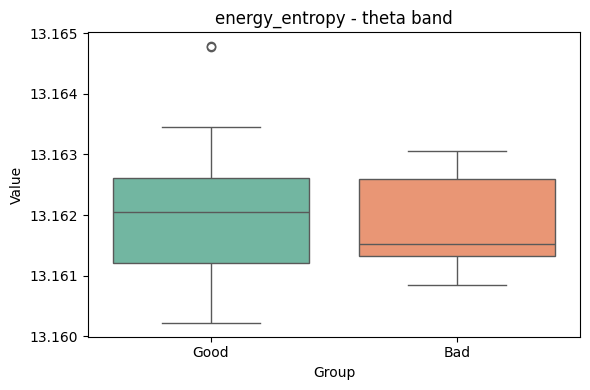

In [105]:
plot_feature_distribution(summary_good, summary_bad, 'energy_entropy', band)

In [96]:
def plot_energy_histogram(features_dict, subject_id, band='alpha', normalized=False):
    energies = features_dict[subject_id][band]['normalized_energies'] if normalized \
               else features_dict[subject_id][band]['energies']
    
    plt.figure(figsize=(6, 3))
    plt.hist(energies, bins=100, color='slateblue', alpha=0.7)
    plt.title(f"{'Normalized' if normalized else 'Raw'} Energy Distribution\nSubject {subject_id} | Band: {band}")
    plt.xlabel("Energy")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

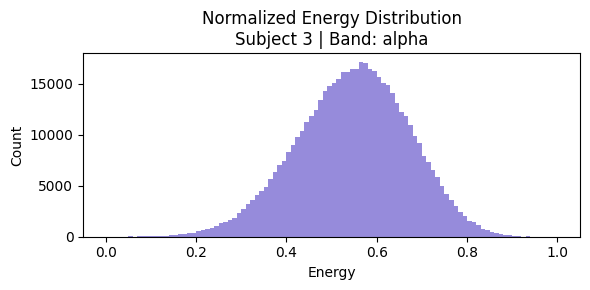

In [97]:
plot_energy_histogram(features_rest, subject_id='3', band='alpha', normalized=True)

In [98]:
def plot_minima_energies(features_dict, subject_id, band='alpha'):
    all_energies = features_dict[subject_id][band]['energies']
    minima_indices = features_dict[subject_id][band]['minima_indices']
    minima_energies = all_energies[minima_indices]

    plt.figure(figsize=(5, 3))
    plt.hist(minima_energies, bins=20, color='darkorange', alpha=0.8)
    plt.title(f"Minima Energies\nSubject {subject_id} | Band: {band}")
    plt.xlabel("Energy")
    plt.ylabel("Number of Minima")
    plt.tight_layout()
    plt.show()


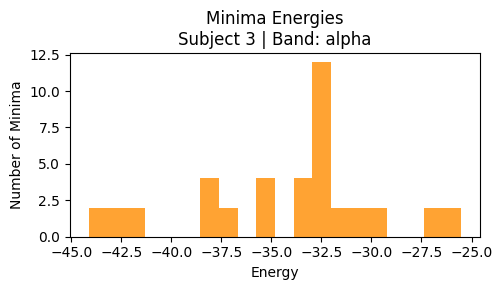

In [108]:
plot_minima_energies(features_rest, subject_id='3', band='alpha')

In [23]:
def print_feature_summary(features_dict, subject_id, band='alpha'):
    f = features_dict[subject_id][band]
    print(f"\n🧠 Subject {subject_id} | Band: {band}")
    print(f"  ▸ Num minima        : {f['num_minima']}")
    print(f"  ▸ Min energy        : {np.min(f['energies']):.3f}")
    print(f"  ▸ Energy entropy    : {entropy(np.exp(-f['normalized_energies']) / np.sum(np.exp(-f['normalized_energies']))):.3f}")
    print(f"  ▸ Avg energy        : {np.mean(f['energies']):.3f}")
    print(f"  ▸ Energy range      : {np.max(f['energies']) - np.min(f['energies']):.3f}")
    print(f"  ▸ # State samples   : {len(f['energies'])}")


In [24]:
print_feature_summary(features_rest, subject_id='3', band='gamma')


🧠 Subject 3 | Band: gamma
  ▸ Num minima        : 32
  ▸ Min energy        : -41.174
  ▸ Energy entropy    : 13.162
  ▸ Avg energy        : 0.000
  ▸ Energy range      : 73.166
  ▸ # State samples   : 524288


In [25]:
def extract_all_features(landscape):
    energies = landscape['energies']
    norm = (energies - energies.min()) / (energies.max() - energies.min())
    probs = np.exp(-norm)
    probs /= probs.sum()

    return {
        'num_minima': landscape['num_minima'],
        'min_energy': np.min(energies),
        'energy_entropy': entropy(probs),
        'avg_energy': np.mean(energies),
        'energy_range': np.max(energies) - np.min(energies)
    }


In [26]:
def get_group_features(features_dict, subject_ids, band):
    all_features = {k: [] for k in ['num_minima', 'min_energy', 'energy_entropy', 'avg_energy', 'energy_range']}
    
    for sid in subject_ids:
        try:
            feats = extract_all_features(features_dict[sid][band])
            for k in all_features:
                all_features[k].append(feats[k])
        except:
            print(f"Skipping subject {sid} for band {band}")
    return all_features


In [27]:
from scipy.stats import mannwhitneyu

def compare_feature(feature, good_vals, bad_vals, band):
    g_mean = np.mean(good_vals)
    b_mean = np.mean(bad_vals)
    stat, pval = mannwhitneyu(good_vals, bad_vals, alternative='two-sided')
    
    print(f"📊 {feature.upper()} ({band}):")
    print(f"   Good mean: {g_mean:.3f} | Bad mean: {b_mean:.3f} | p = {pval:.4f}")
    return {'feature': feature, 'band': band, 'good_mean': g_mean, 'bad_mean': b_mean, 'p': pval}


In [28]:
def full_group_comparison(features_dict, good_ids, bad_ids, bands=['theta', 'alpha', 'beta', 'gamma', 'broadband']):
    results = []
    for band in bands:
        good_feats = get_group_features(features_dict, good_ids, band)
        bad_feats = get_group_features(features_dict, bad_ids, band)

        for feature in good_feats:
            result = compare_feature(feature, good_feats[feature], bad_feats[feature], band)
            results.append(result)
    return results


In [32]:
with open("landscape_features/features_task.pkl", "rb") as f:
    features_task = pickle.load(f)

# Run
results_task = full_group_comparison(features_rest, good_counters, bad_counters)


📊 NUM_MINIMA (theta):
   Good mean: 32.346 | Bad mean: 35.300 | p = 0.2088
📊 MIN_ENERGY (theta):
   Good mean: -45.135 | Bad mean: -44.816 | p = 0.9016
📊 ENERGY_ENTROPY (theta):
   Good mean: 13.162 | Bad mean: 13.162 | p = 0.9296
📊 AVG_ENERGY (theta):
   Good mean: 0.000 | Bad mean: 0.000 | p = 1.0000
📊 ENERGY_RANGE (theta):
   Good mean: 83.553 | Bad mean: 84.729 | p = 0.3869
📊 NUM_MINIMA (alpha):
   Good mean: 30.923 | Bad mean: 29.500 | p = 1.0000
📊 MIN_ENERGY (alpha):
   Good mean: -55.135 | Bad mean: -55.983 | p = 0.9859
📊 ENERGY_ENTROPY (alpha):
   Good mean: 13.162 | Bad mean: 13.162 | p = 0.2230
📊 AVG_ENERGY (alpha):
   Good mean: 0.000 | Bad mean: -0.000 | p = 0.1570
📊 ENERGY_RANGE (alpha):
   Good mean: 92.868 | Bad mean: 95.813 | p = 0.4690
📊 NUM_MINIMA (beta):
   Good mean: 31.692 | Bad mean: 28.900 | p = 0.6201
📊 MIN_ENERGY (beta):
   Good mean: -48.209 | Bad mean: -48.592 | p = 0.7108
📊 ENERGY_ENTROPY (beta):
   Good mean: 13.162 | Bad mean: 13.162 | p = 0.9016
📊 AVG_ENE

/home/donaf-strange/anaconda3/envs/neuro_env/fsl/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/donaf-strange/anaconda3/envs/neuro_env/fsl/lib/python3.12/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_2313206/3589370174.py:6: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  stat, pval = mannwhitneyu(good_vals, bad_vals, alternative='two-sided')


In [30]:
with open("landscape_features/features_rest.pkl", "rb") as f:
    features_rest = pickle.load(f)

# Run
results_rest = full_group_comparison(features_rest, good_counters, bad_counters)

📊 NUM_MINIMA (theta):
   Good mean: 32.346 | Bad mean: 35.300 | p = 0.2088
📊 MIN_ENERGY (theta):
   Good mean: -45.135 | Bad mean: -44.816 | p = 0.9016
📊 ENERGY_ENTROPY (theta):
   Good mean: 13.162 | Bad mean: 13.162 | p = 0.9296
📊 AVG_ENERGY (theta):
   Good mean: 0.000 | Bad mean: 0.000 | p = 1.0000
📊 ENERGY_RANGE (theta):
   Good mean: 83.553 | Bad mean: 84.729 | p = 0.3869
📊 NUM_MINIMA (alpha):
   Good mean: 30.923 | Bad mean: 29.500 | p = 1.0000
📊 MIN_ENERGY (alpha):
   Good mean: -55.135 | Bad mean: -55.983 | p = 0.9859
📊 ENERGY_ENTROPY (alpha):
   Good mean: 13.162 | Bad mean: 13.162 | p = 0.2230
📊 AVG_ENERGY (alpha):
   Good mean: 0.000 | Bad mean: -0.000 | p = 0.1570
📊 ENERGY_RANGE (alpha):
   Good mean: 92.868 | Bad mean: 95.813 | p = 0.4690
📊 NUM_MINIMA (beta):
   Good mean: 31.692 | Bad mean: 28.900 | p = 0.6201
📊 MIN_ENERGY (beta):
   Good mean: -48.209 | Bad mean: -48.592 | p = 0.7108
📊 ENERGY_ENTROPY (beta):
   Good mean: 13.162 | Bad mean: 13.162 | p = 0.9016
📊 AVG_ENE

/home/donaf-strange/anaconda3/envs/neuro_env/fsl/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/donaf-strange/anaconda3/envs/neuro_env/fsl/lib/python3.12/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_2313206/3589370174.py:6: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  stat, pval = mannwhitneyu(good_vals, bad_vals, alternative='two-sided')


In [ ]:
Path("all_features").mkdir(exist_ok=True)

# Save the dictionary for ML use
with open("all_features/Advance_features_rest.pkl", "wb") as f:
    pickle.dump(features_rest, f)

print("✅ Saved Advance features to all_features/Advance_features_rest.pkl")




✅ Saved Advance features to all_features/Advance_features_rest.pkl


NameError: name 'features_task' is not defined

In [33]:
# Save the dictionary for ML use
with open("all_features/Advance_features_task.pkl", "wb") as f:
    pickle.dump(features_task, f)

print("✅ Saved Advance features to all_features/Advance_features_task.pkl")

✅ Saved Advance features to all_features/Advance_features_task.pkl


let’s clarify what **bands** and **features** you've extracted so far:

---

## ✅ **BANDS** You've Processed

From your `preprocess_subject()` and binarization steps, you extracted the following **frequency bands** per subject:

| Band        | Frequency Range (Hz) |
| ----------- | -------------------- |
| `theta`     | 4–8 Hz               |
| `alpha`     | 8–12 Hz              |
| `beta`      | 12–30 Hz             |
| `gamma`     | 30–45 Hz             |
| `broadband` | 1–45 Hz              |

So you should have results for **five bands** per subject in both rest and task conditions.

---

## ✅ **Features Extracted per Band (from the Ising model landscape)**

These are extracted in `extract_landscape_features()` + `summarize_features()`:

| Feature Name          | Description                                                           |
| --------------------- | --------------------------------------------------------------------- |
| `num_minima`          | Number of local energy minima in the full state space                 |
| `energies`            | Energy values for all $2^n$ possible binary states                    |
| `normalized_energies` | Min-max scaled energy values (used to define Boltzmann probabilities) |
| `minima_indices`      | Index positions of local minima in state space                        |
| `energy_entropy`      | Entropy of the Boltzmann distribution $\propto e^{-E(s)}$             |
| `min_energy`          | The energy of the global minimum (deepest attractor)                  |

---

### ✅ Summary:

You have the following features **per subject × band**:

| Band        | Features                                     |
| ----------- | -------------------------------------------- |
| `theta`     | `num_minima`, `min_energy`, `energy_entropy` |
| `alpha`     | 〃                                            |
| `beta`      | 〃                                            |
| `gamma`     | 〃                                            |
| `broadband` | 〃                                            |

---

If you saved these into the dictionaries like:

```python
features_rest['subject_id']['alpha']['num_minima']
```

then you have full access to all **5 bands × 3 main features × 2 conditions (rest/task)**.

---

Would you like a function that loops over **all bands and features** to generate group-level comparison tables automatically?




---

## ✅ 1. **Core Features You've Already Extracted**

| Feature Name          | Type                   | Description                                                |
| --------------------- | ---------------------- | ---------------------------------------------------------- |
| `num_minima`          | **Topological**        | Number of local minima in energy landscape                 |
| `min_energy`          | **Energetic**          | Minimum energy across all possible states                  |
| `energies`            | **Energetic**          | Energy values for all $2^n$ states                         |
| `normalized_energies` | **Energetic (scaled)** | Energies scaled between 0 and 1                            |
| `minima_indices`      | **Topological**        | Indices of local minima in the state space                 |
| `energy_entropy`      | **Informational**      | Entropy of Boltzmann distribution $P(s) \propto e^{-E(s)}$ |

These capture **stability**, **diversity**, and **depth** of your system’s landscape.

---

## 🔍 2. **Optional Features You *Can* Extract (from the same data)**

These features aren't yet extracted, but your current `energies` and `minima_indices` can easily be extended to compute:

### A. **Basin Size per Minimum**

* Estimate the number of neighboring states that fall into each minimum
* Requires **gradient descent simulation** in state space
* Could yield:

  * `mean_basin_size`
  * `basin_entropy` (distributional entropy across basins)

---

### B. **Transition Entropy**

* Define a Markov process where transitions happen between neighboring states based on energy difference
* Measure uncertainty over transitions
* Reflects **state switching richness**

---

### C. **Disconnectivity Graph Features**

* Depths of basins and energy barriers between them
* Number of metastable states
* Graph-based metrics (diameter, clustering)

---

### D. **Multistability Score**

* Difference between deepest and shallowest local minima
* A simple measure of attractor diversity

---

### E. **Mean / Median Energy**

* Mean of all $E(s)$
* May reflect overall excitation level

---

## 📦 So, in Total:

| Category          | Features Extracted                              | Features Possible                                                |
| ----------------- | ----------------------------------------------- | ---------------------------------------------------------------- |
| **Topological**   | `num_minima`, `minima_indices`                  | `mean_basin_size`, `basin_entropy`, `disconnectivity depth`      |
| **Energetic**     | `energies`, `min_energy`, `normalized_energies` | `mean_energy`, `median_energy`, `energy_range`, `multistability` |
| **Informational** | `energy_entropy`                                | `transition_entropy`                                             |

---



In [127]:
with open("landscape_features/features_task.pkl", "rb") as f:
    features_rest = pickle.load(f)

In [136]:
import pymc as pm
import arviz as az

def bayesian_compare(good_vals, bad_vals, feature, band):
    with pm.Model() as model:
        mu_good = pm.Normal("mu_good", mu=0, sigma=10)
        mu_bad = pm.Normal("mu_bad", mu=0, sigma=10)
        sigma = pm.HalfNormal("sigma", sigma=10)
        
        y_good = pm.Normal("y_good", mu=mu_good, sigma=sigma, observed=good_vals)
        y_bad = pm.Normal("y_bad", mu=mu_bad, sigma=sigma, observed=bad_vals)
        
        diff = pm.Deterministic("diff", mu_good - mu_bad)
        trace = pm.sample(2000, tune=1000, target_accept=0.95, progressbar=False, return_inferencedata=True)
        '''trace = pm.sample(
        draws=2000,
        tune=1000,
        target_accept=0.95,        # ← More conservative, fewer divergences
        max_treedepth=15,          # ← Allows deeper exploration of the posterior
        return_inferencedata=True,
        progressbar=False
        )'''

    az.plot_posterior(trace, var_names=["diff"], ref_val=0)
    summary = az.summary(trace, var_names=["diff"], hdi_prob=0.95)

    print(f"\n📊 Bayesian comparison for {feature.upper()} in {band.upper()}:")
    print(summary)
    
    return {
        'feature': feature,
        'band': band,
        'diff_mean': summary.loc['diff', 'mean'],
        'hdi_2.5%': summary.loc['diff', 'hdi_2.5%'],
        'hdi_97.5%': summary.loc['diff', 'hdi_97.5%'],
        'prob_positive': (trace.posterior["diff"] > 0).mean().item()
    }

def sample_model(hard_mode=False, extra_robust=False):
    if extra_robust:
        return pm.sample(draws=5000, tune=2000, target_accept=0.98,
                         max_treedepth=20, return_inferencedata=True)
    elif hard_mode:
        return pm.sample(draws=3000, tune=1500, target_accept=0.97,
                         max_treedepth=20, return_inferencedata=True)
    else:
        return pm.sample(draws=2000, tune=1000, target_accept=0.95,
                         max_treedepth=15, return_inferencedata=True)

trace = sample_model(hard_mode=(feature_name == 'avg_energy'))


for feature_name in ['num_minima', 'min_energy', 'energy_entropy', 'avg_energy', 'energy_range']:
    trace = sample_model(hard_mode=(feature_name == 'avg_energy'))

def sample_model(feature_name=None):
    if feature_name == 'avg_energy':
        return pm.sample(draws=3000, tune=1500, target_accept=0.97,
                         max_treedepth=20, return_inferencedata=True)
    else:
        return pm.sample(draws=2000, tune=1000, target_accept=0.95,
                         max_treedepth=15, return_inferencedata=True)
trace = sample_model(feature_name)


In [133]:
def aggregate_group_features(features_dict, subjects, band):
    feature_list = []
    for sid in subjects:
        try:
            if band in features_dict[sid]:
                feature_list.append(extract_all_features(features_dict[sid][band]))
        except:
            continue
    return feature_list

def run_bayesian_analysis_all(features_dict, good_ids, bad_ids, bands=['theta', 'alpha', 'beta', 'gamma']):
    results = []
    for band in bands:
        good = aggregate_group_features(features_dict, good_ids, band)
        bad = aggregate_group_features(features_dict, bad_ids, band)

        if not good or not bad:
            continue

        for feature in good[0].keys():
            try:
                good_vals = [g[feature] for g in good]
                bad_vals = [b[feature] for b in bad]
                result = bayesian_compare(good_vals, bad_vals, feature, band)
                results.append(result)
            except Exception as e:
                print(f"❌ Skipped {feature} in {band}: {e}")
    return results


In [134]:
def run_bayesian_analysis_all(features_dict, good_ids=good_counters, bad_ids=bad_counters, bands=['theta', 'alpha', 'beta', 'gamma']):
    results = []
    for band in bands:
        good_feats = get_group_features(features_dict, good_ids, band)
        bad_feats = get_group_features(features_dict, bad_ids, band)

        for feature in good_feats:
            try:
                good_vals = good_feats[feature]
                bad_vals = bad_feats[feature]
                result = bayesian_compare(good_vals, bad_vals, feature, band)
                results.append(result)
            except Exception as e:
                print(f"❌ Skipped {feature} in {band}: {e}")

    return results


Sampling 4 chains for 1_000 tune and 1_929 draw iterations (4_000 + 7_716 draws total) took 60 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...



📊 Bayesian comparison for AVG_ENERGY in BETA:
      mean   sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
diff   0.0  0.0      -0.0        0.0        0.0      0.0    6570.0    5047.0   

      r_hat  
diff   1.04  


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_good, mu_bad, sigma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 5 seconds.



📊 Bayesian comparison for ENERGY_RANGE in BETA:
       mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
diff  7.006  5.691    -3.643     18.506      0.103    0.099    3410.0   

      ess_tail  r_hat  
diff    3027.0    1.0  


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_good, mu_bad, sigma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.
Initializing NUTS using jitter+adapt_diag...



📊 Bayesian comparison for NUM_MINIMA in GAMMA:
       mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
diff -0.827  3.639    -8.099       6.22      0.045    0.044    6571.0   

      ess_tail  r_hat  
diff    5089.0    1.0  


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_good, mu_bad, sigma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.
Initializing NUTS using jitter+adapt_diag...



📊 Bayesian comparison for MIN_ENERGY in GAMMA:
       mean    sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
diff -0.914  1.96    -4.837       2.84      0.024    0.023    6627.0   

      ess_tail  r_hat  
diff    5249.0    1.0  


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_good, mu_bad, sigma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.
Initializing NUTS using jitter+adapt_diag...



📊 Bayesian comparison for ENERGY_ENTROPY in GAMMA:
       mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
diff  0.001  0.001      -0.0      0.002        0.0      0.0    7502.0   

      ess_tail  r_hat  
diff    5363.0    1.0  


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_good, mu_bad, sigma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 57 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_dia


📊 Bayesian comparison for AVG_ENERGY in GAMMA:
      mean   sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
diff   0.0  0.0      -0.0        0.0        0.0      0.0    6946.0     100.0   

      r_hat  
diff   1.08  


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_good, mu_bad, sigma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.



📊 Bayesian comparison for ENERGY_RANGE in GAMMA:
       mean    sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
diff  2.477  2.48    -2.348      7.401      0.033    0.034    5872.0   

      ess_tail  r_hat  
diff    4565.0    1.0  


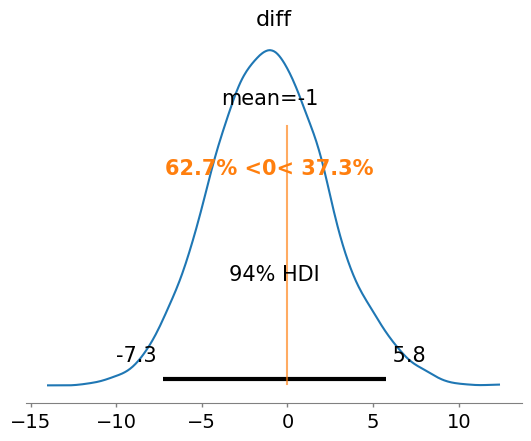

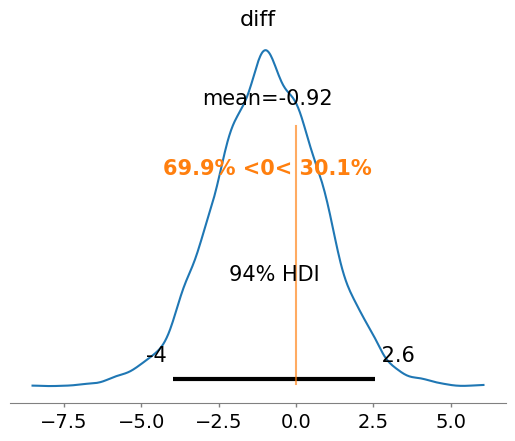

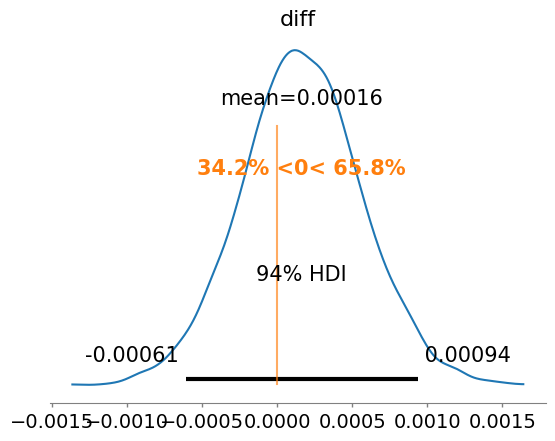

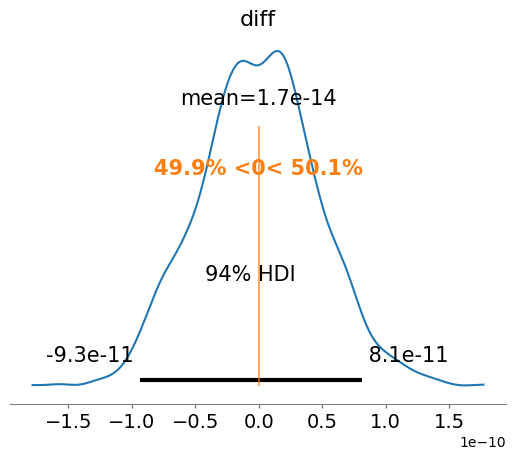

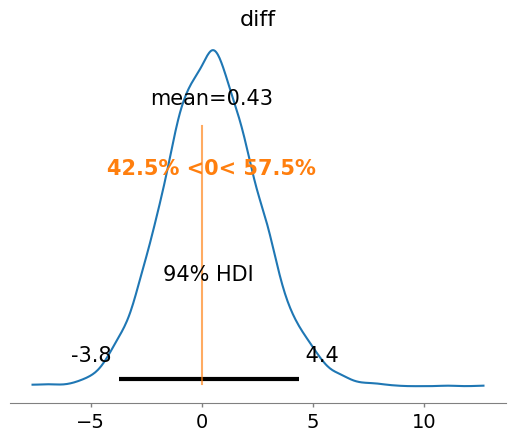

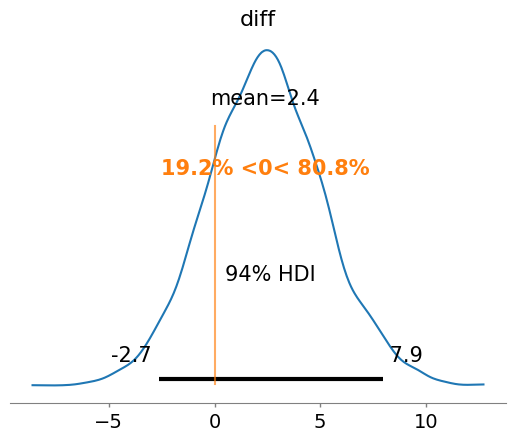

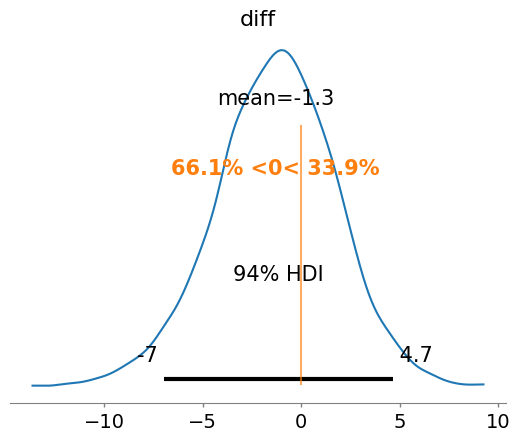

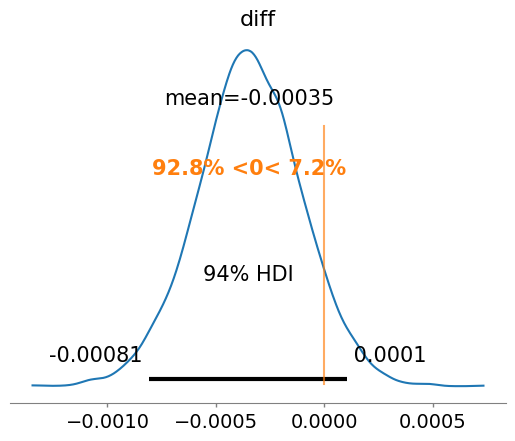

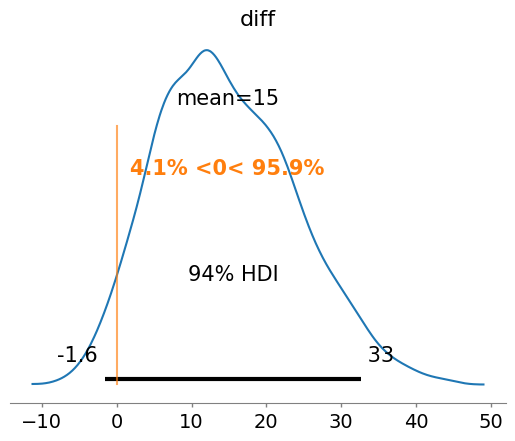

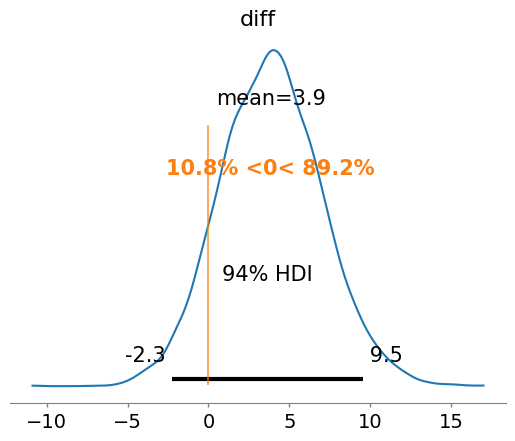

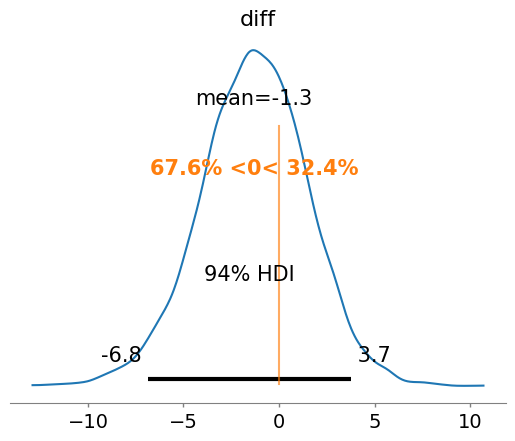

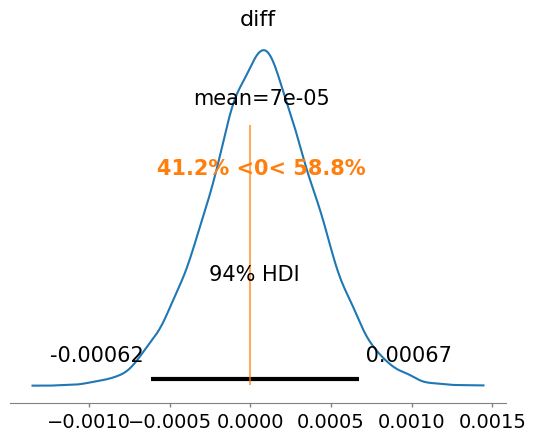

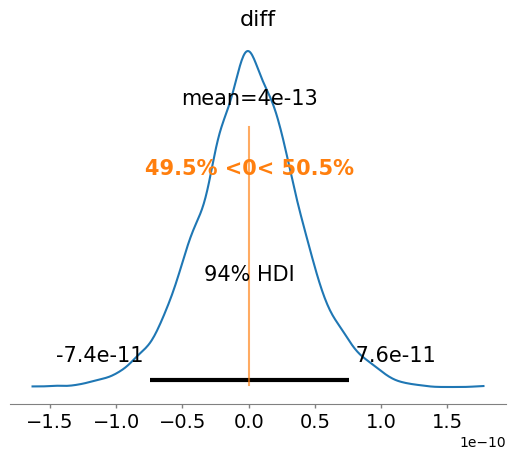

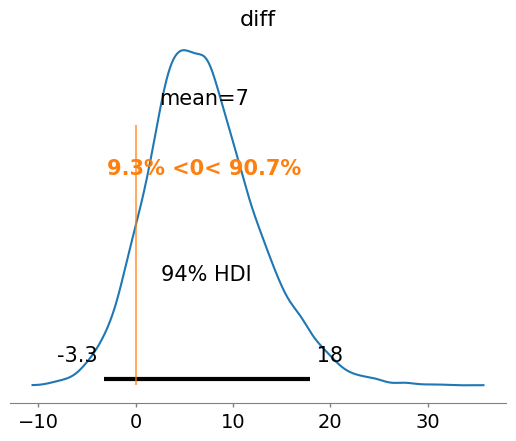

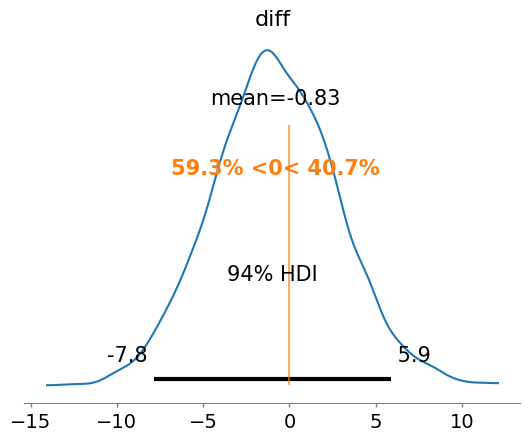

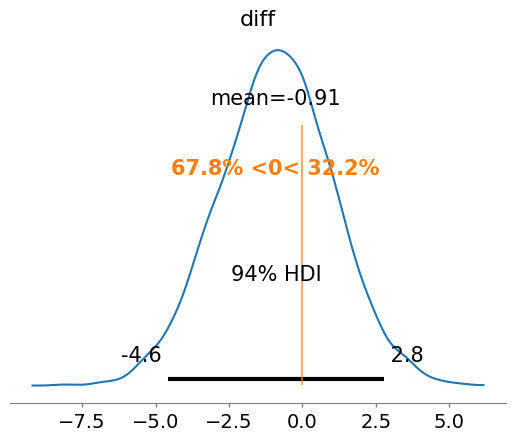

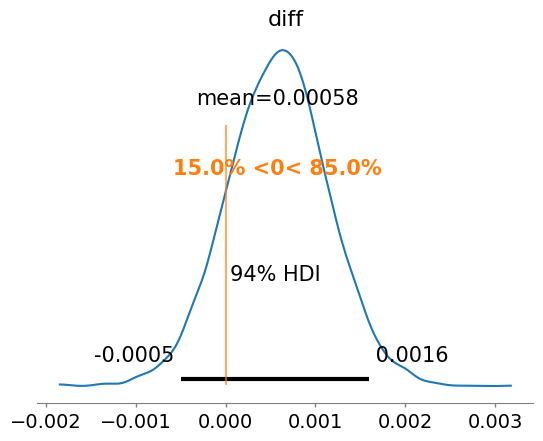

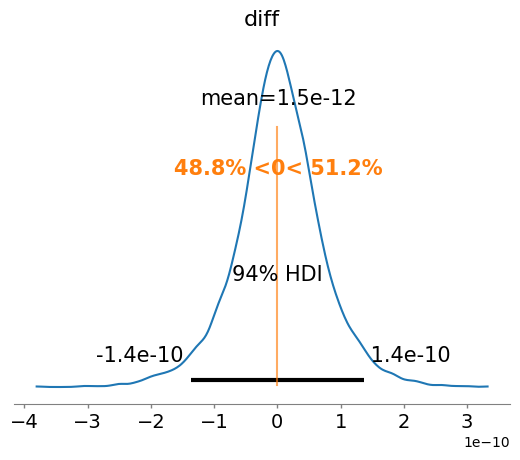

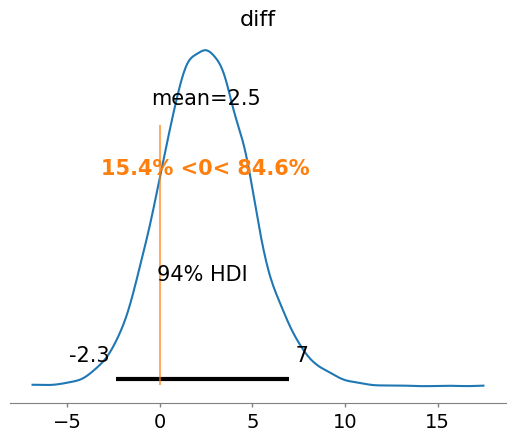

In [137]:
results = run_bayesian_analysis_all(features_rest, good_counters, bad_counters)

In [ ]:
results = run_bayesian_analysis_all(features_rest, good_counters, bad_counters)

Most Promising Differences: from rest
| Feature        | Band       | Effect                 |
| -------------- | ---------- | ---------------------- |
| `NUM_MINIMA`   | Beta       | Higher in Good (trend) |
| `ENERGY_RANGE` | Alpha/Beta | Wider in Good group    |

1. NUM_MINIMA

| Band  | Mean Difference | 95% HDI        | Interpretation                          |
| ----- | --------------- | -------------- | --------------------------------------- |
| Theta | -1.04           | \[-7.64, 5.83] | ✅ HDI includes 0 → no strong difference |
| Alpha | **+2.30**       | \[-2.85, 7.91] | ↗️ Trend but HDI includes 0             |
| Beta  | **+3.93**       | \[-2.32, 9.74] | ↗️ Slight evidence, but still uncertain |
| Gamma | -0.71           | \[-7.94, 6.44] | ❌ No evidence                           |

2. MIN_ENERGY

| Band  | Mean Diff | HDI            | Interpretation        |
| ----- | --------- | -------------- | --------------------- |
| Theta | -0.94     | \[-4.37, 2.53] | ❌ No evidence         |
| Alpha | -1.29     | \[-7.46, 4.41] | ❌ Still overlaps 0    |
| Beta  | -1.26     | \[-7.09, 4.17] | ❌ No group difference |
| Gamma | -0.88     | \[-4.81, 2.90] | ❌ No group difference |

3. ENERGY_ENTROPY

| Band  | Mean Diff | HDI              | Interpretation                   |
| ----- | --------- | ---------------- | -------------------------------- |
| Theta | 0.0       | \[-0.001, 0.001] | ❌ Flat → identical across groups |
| Alpha | -0.0      | \[-0.001, 0.0]   | ❌ Very small                     |
| Beta  | 0.0       | \[-0.001, 0.001] | ❌ Not meaningful                 |
| Gamma | 0.001     | \[-0.001, 0.002] | ❌ Tiny effect                    |

4. AVG_ENERGY

| Band  | Mean Diff | HDI          | Warnings?        |
| ----- | --------- | ------------ | ---------------- |
| Theta | 0.0       | \[-0.0, 0.0] | ⚠️ r\_hat > 1.01 |
| Alpha | -0.0      | \[-0.0, 0.0] | ⚠️ Same          |
| Beta  | 0.0       | \[-0.0, 0.0] | ⚠️ Same          |
| Gamma | 0.0       | \[-0.0, 0.0] | ✅ Fine           |

5. ENERGY_RANGE

| Band  | Mean Diff  | HDI             | Interpretation                     |
| ----- | ---------- | --------------- | ---------------------------------- |
| Theta | +0.46      | \[-3.61, 4.88]  | ❌ No effect                        |
| Alpha | **+14.51** | \[-1.84, 34.24] | ↗️ Potential difference (wide HDI) |
| Beta  | **+6.86**  | \[-3.56, 18.67] | ↗️ Interesting trend               |
| Gamma | +2.43      | \[-2.18, 7.48]  | ↗️ Not significant                 |



nothing

In [139]:
3+3
4+4

8